# Error Analysis

## Preprocessing - Sampling according to the errors distribution

In [3]:
from pathlib import Path
from collections import defaultdict
import re

graphviz_trees_dir = Path('output/qpl/text_to_qpl/graphviz_trees')

db_count = defaultdict(int)
db_err_count = defaultdict(int)
for file in graphviz_trees_dir.glob('*.svg'):
    match = re.match(r'^(\d+)_(.+?)(?:_(error))?$', file.stem, re.DOTALL)
    if not match:
        raise ValueError(f"Unexpected file name format: {file.stem}")
    id, db_name, error = match.groups()
    db_count[db_name] += 1
    if error:
        db_err_count[db_name] += 1

Target sample size: 100  |  Achieved: 100


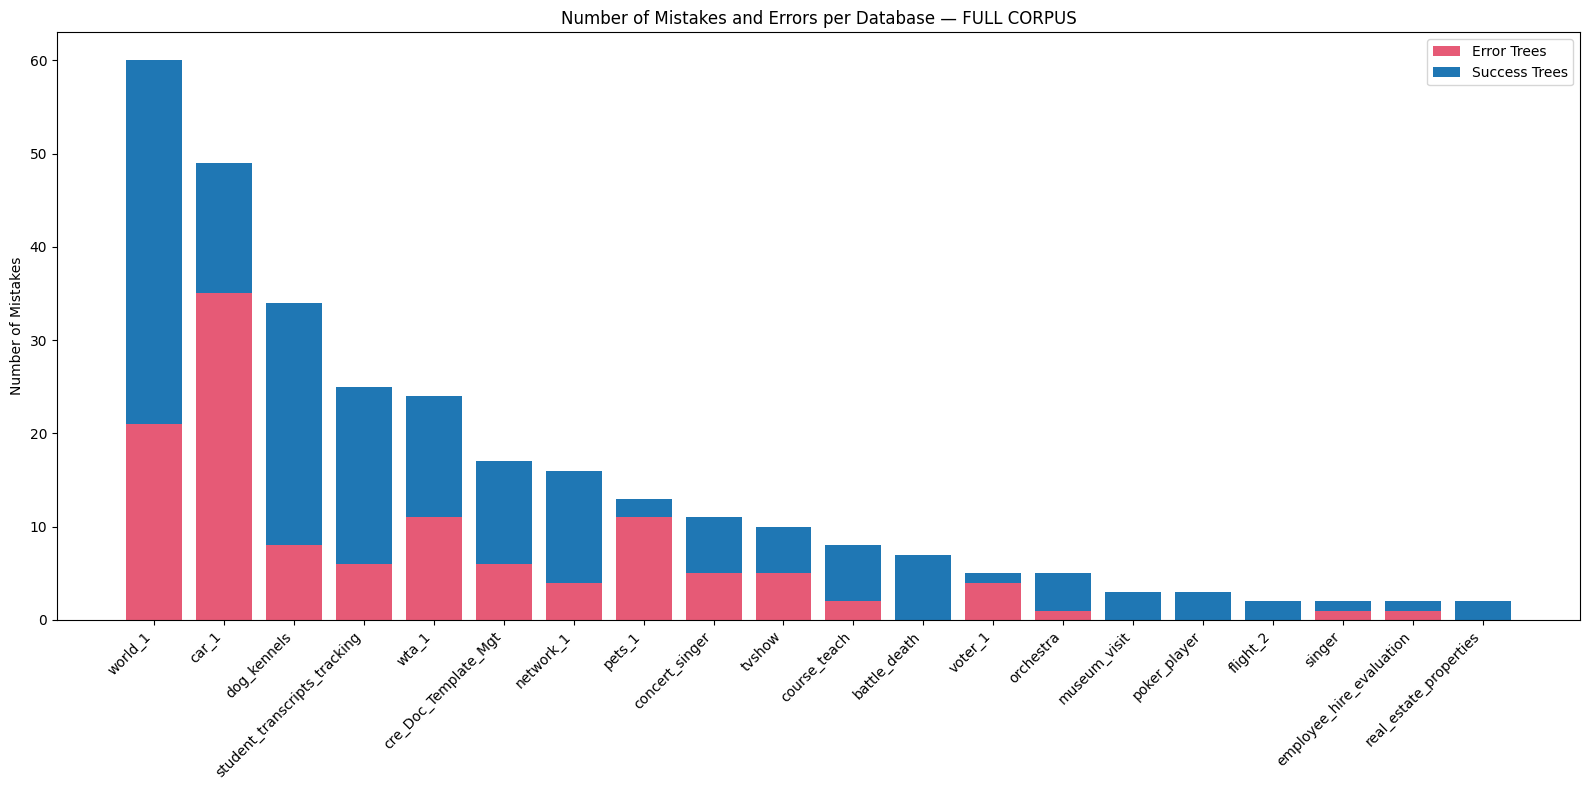

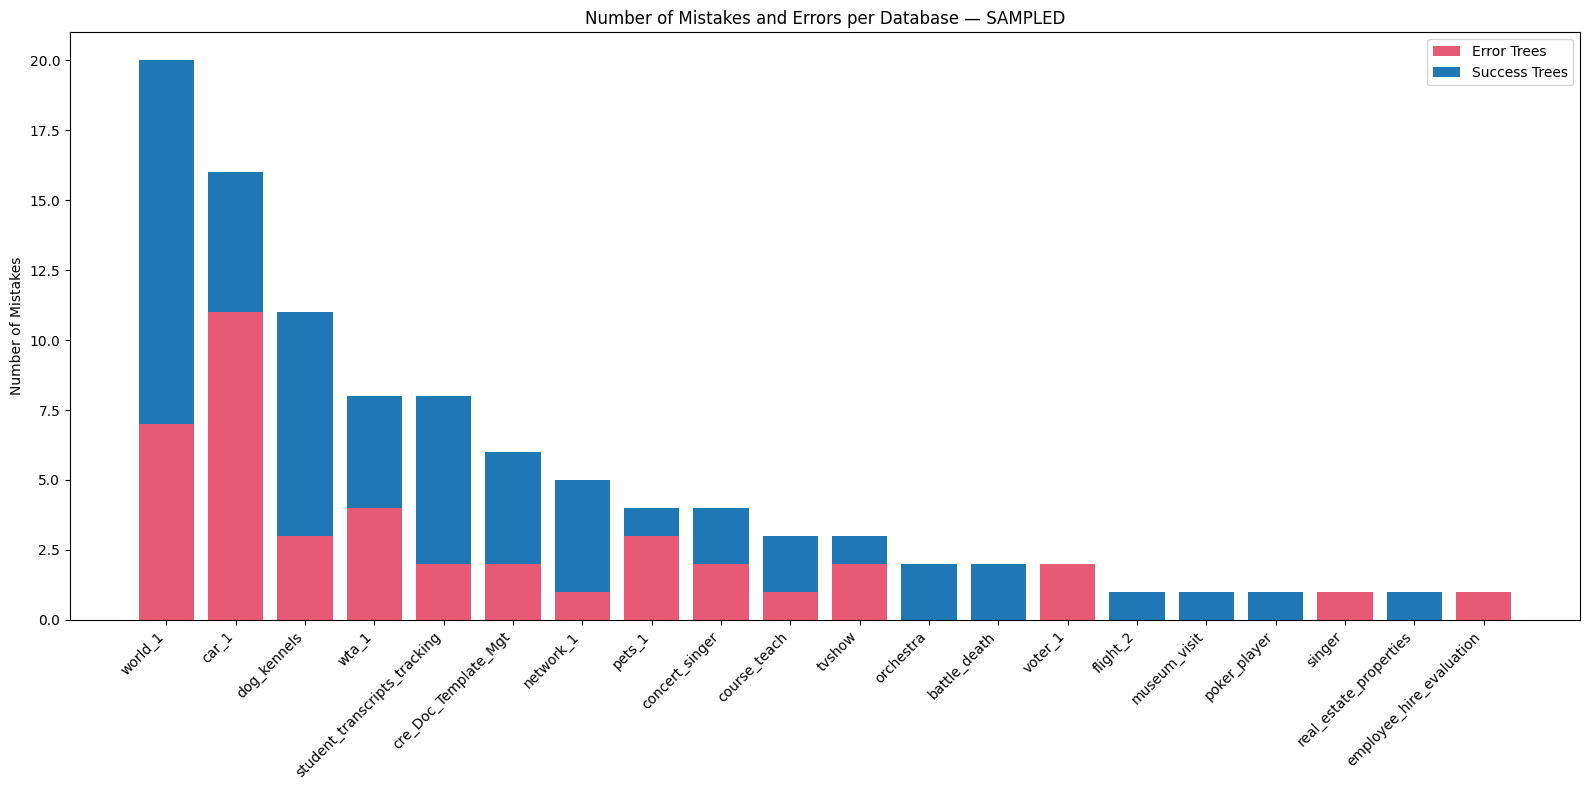

In [4]:
from pathlib import Path
from collections import defaultdict
import random, re
import matplotlib.pyplot as plt

# ---------------------------------------------------------------------
# CONFIG ----------------------------------------------------------------
graphviz_trees_dir = Path("output/qpl/text_to_qpl/graphviz_trees")
SAMPLE_SIZE        = 100          # <- change to taste
RANDOM_SEED        = 202507       # set None for a new shuffle each run
# ---------------------------------------------------------------------


########################################################################
# 0.  Helpers
########################################################################
def integer_quotas(total, weights):
    """
    Largest-remainder rounding: return list[int] whose sum == total
    and that are proportional to `weights` (assumed to sum to 1).
    """
    ideal  = [w * total for w in weights]
    floor  = [int(x) for x in ideal]
    rem    = total - sum(floor)
    frac   = [x - intx for x, intx in zip(ideal, floor)]
    for i in sorted(range(len(frac)), key=lambda i: frac[i], reverse=True)[:rem]:
        floor[i] += 1
    return floor


def make_histogram(file_list, title):
    cnt, err = defaultdict(int), defaultdict(int)
    for p in file_list:
        m = re.match(r"^\d+_(.+?)(?:_(error))?$", p.stem)
        if not m:
            raise ValueError(f"Unexpected filename: {p.name}")
        db, error = m.groups()
        is_error  = bool(error)
        cnt[db]  += 1
        err[db]  += is_error

    dbs       = list(cnt.keys())
    successes = [cnt[d] - err[d] for d in dbs]   # blue segment
    errors    = [err[d]           for d in dbs]  # red segment
    totals    = [s + e for s, e in zip(successes, errors)]

    # sort bars by total descending
    sorted_data = sorted(
        zip(dbs, successes, errors, totals),
        key=lambda x: x[3],
        reverse=True
    )
    if len(sorted_data) == 1:
        dbs, successes, errors, _ = [list(t) for t in zip(*sorted_data, strict=False)]
    else:
        dbs, successes, errors, _ = map(list, zip(*sorted_data))

    plt.figure(figsize=(16, 8))
    plt.bar(dbs, errors,           label="Error Trees",   color="crimson", alpha=0.7)
    plt.bar(dbs, successes, bottom=errors, label="Success Trees")
    plt.xticks(rotation=45, ha="right")
    plt.ylabel("Number of Mistakes")
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.show()



########################################################################
# 1.  Scan directory — build full list of records & corpus statistics
########################################################################
records       = []                   # [(Path, db, is_error), ...]
db_count      = defaultdict(int)     # total files per DB
db_err_count  = defaultdict(int)     # error files per DB

for f in graphviz_trees_dir.glob("*.svg"):
    m = re.match(r"^\d+_(.+?)(?:_(error))?$", f.stem)
    if not m:
        raise ValueError(f"Bad file name: {f.name}")
    db, error = m.groups()
    is_err = bool(error)
    db_count[db]     += 1
    db_err_count[db] += is_err
    records.append((f, db, is_err))

total_files = len(records)
if total_files == 0:
    raise RuntimeError("No SVG files found — check the directory path.")

########################################################################
# 2.  Proportional *integer* quotas, then clip & redistribute
########################################################################
# 2a. per-database integer quotas
db_names   = list(db_count)
db_weights = [db_count[d] / total_files for d in db_names]
db_targets = dict(zip(db_names, integer_quotas(SAMPLE_SIZE, db_weights)))

# 2b. split each DB target into error / success quotas
quota = {}            # key = (db, is_error)  ->  integer target
for db in db_names:
    total, err = db_count[db], db_err_count[db]
    ok = total - err
    if total == 0:
        quota[(db, True)] = quota[(db, False)] = 0
        continue
    err_q, ok_q = integer_quotas(db_targets[db], [err / total, ok / total])
    quota[(db, True)]  = err_q
    quota[(db, False)] = ok_q

########################################################################
# 3.  Ensure quotas don’t exceed slice sizes; redistribute any deficit
########################################################################
# Build pools for easy access
pools = defaultdict(list)
for f, db, is_err in records:
    pools[(db, is_err)].append(f)

# 3a. Clip quotas that overshoot
deficit = 0
for key, q in quota.items():
    cap = len(pools[key])
    if q > cap:
        deficit += q - cap
        quota[key] = cap

# 3b. Redistribute the deficit to slices with spare capacity
while deficit:
    # slices that can still take ≥1 more file
    candidates = [k for k in quota if quota[k] < len(pools[k])]
    if not candidates:
        # cannot reach SAMPLE_SIZE without replacement
        break
    for k in sorted(candidates, key=lambda k: len(pools[k]) - quota[k], reverse=True):
        if deficit == 0:
            break
        quota[k] += 1
        deficit -= 1

actual_sample_size = sum(quota.values())
print(f"Target sample size: {SAMPLE_SIZE}  |  Achieved: {actual_sample_size}")

########################################################################
# 4.  Stratified sampling without replacement
########################################################################
rng     = random.Random(RANDOM_SEED)
sampled = []

for key, target in quota.items():
    sampled.extend(rng.sample(pools[key], target))

rng.shuffle(sampled)

########################################################################
# 5.  Plot full corpus vs. sampled distribution
########################################################################
make_histogram([r[0] for r in records],
               "Number of Mistakes and Errors per Database — FULL CORPUS")

make_histogram(sampled,
               "Number of Mistakes and Errors per Database — SAMPLED")


In [5]:
sampled[:5]

[PosixPath('output/qpl/text_to_qpl/graphviz_trees/261_network_1.svg'),
 PosixPath('output/qpl/text_to_qpl/graphviz_trees/76_flight_2.svg'),
 PosixPath('output/qpl/text_to_qpl/graphviz_trees/88_cre_Doc_Template_Mgt_error.svg'),
 PosixPath('output/qpl/text_to_qpl/graphviz_trees/111_wta_1.svg'),
 PosixPath('output/qpl/text_to_qpl/graphviz_trees/104_museum_visit.svg')]

In [6]:
import csv
import os

# Create a list of dictionaries with the extracted information
sampled_data = []
for file_path in sampled:
    match = re.match(r'^(\d+)_(.+?)(?:_(error))?$', file_path.stem, re.DOTALL)
    if match:
        id, db_name, error = match.groups()
        sampled_data.append({
            'ID': id,
            'DB': db_name,
            'Error': 'Yes' if error else 'No',
        })

# Write to CSV
csv_path = Path("output/qpl/text_to_qpl/sampled_metadata.csv")
with open(csv_path, 'w', newline='') as csvfile:
    fieldnames = ['ID', 'DB', 'Error']
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
    
    writer.writeheader()
    for row in sampled_data:
        writer.writerow(row)

print(f"CSV file created at {csv_path} with {len(sampled_data)} entries")

CSV file created at output/qpl/text_to_qpl/sampled_metadata.csv with 100 entries


In [7]:
import shutil

sampled_dir = Path("output/qpl/text_to_qpl/sampled_trees")
sampled_dir.mkdir(parents=True, exist_ok=True)
for file in sampled:
    shutil.copy(file, sampled_dir)

## Analyzing the Errors

In [13]:
import pandas as pd

errors = pd.read_excel("Error Analysis.xlsx")
errors.head()

,ID,DB,Error,Gold Nodes,Predicted Nodes,Problematic Node(s),Error Category,Responsible Component,Explanation
0,4,concert_singer,No,4,2,#2,Ambiguous Decomposition (id/name),Decomposer,The question did not state that the query shou...
1,7,concert_singer,No,1,1,#1,Wrong Column Selection,Completer,"The completer returned ""Is_male"" instead of ""N..."
2,9,concert_singer,Yes,5,5,#4,Information Omission (Column),Decomposer,"The ""capacity"" information has been ommited in..."
3,10,concert_singer,Yes,5,5,#4,Information Omission (Column),Decomposer,"The ""capacity"" information has been ommited in..."
4,12,pets_1,No,6,4,#3,Information Omission (Value),Decomposer,"The ""PetType=dog"" information has been omitted..."


### Error Count Per Category

In [39]:
from collections import Counter

categories = Counter(c.strip() for lst in errors['Error Category'].str.split(',') for c in lst)
categories = dict(sorted(categories.items(), key=lambda x: x[1], reverse=True))
categories

{'Incorrect Scan (Join - Column/Column)': 16,
 'Incorrect Scan (Join - Value/Column)': 12,
 'Information Omission (Column)': 11,
 'Wrong Decomposition': 11,
 'Missing Distinct': 8,
 'Wrong Column Selection': 7,
 'Ambiguous Decomposition (id/name)': 5,
 'Wrong Value Selection': 5,
 'Incorrect Scan (Union)': 4,
 'Execution Accuracy Bug (Different Alias)': 3,
 'Incorrect Gold': 3,
 'Vague Question': 3,
 'Wrong Table Selection': 3,
 'Information Modification (Column)': 3,
 'Wrong Predicate (Broadening)': 3,
 'Incorrect Scan (Aggregate)': 2,
 'Incorrect Scan (Except)': 2,
 'Non-Realistic Database': 2,
 'Information Omission (Value)': 1,
 'Incorrect Aggregate (Join)': 1,
 'Redundent Join': 1,
 'Wrong Predicate (Inverted Range)': 1,
 'Ambiguous Database': 1,
 'Wrong Predicate (Narrowing)': 1,
 'Incorrect Aggregate (Scan)': 1,
 'Information Addition (Column)': 1,
 'Incorrect Filter (Join)': 1,
 'Incorrect Aggregate (Filter)': 1,
 'Execution Accuracy Bug (TopSort)': 1,
 'Set-Wise Operation on N

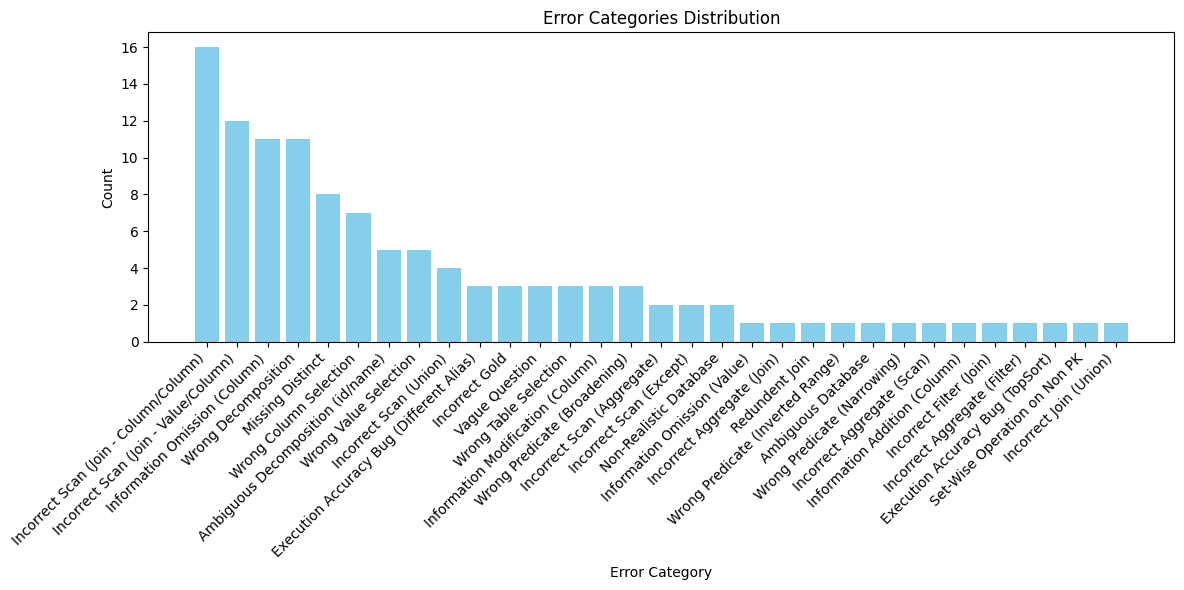

In [ ]:
# show histogram of categories
from matplotlib import pyplot as plt

plt.figure(figsize=(12, 6))
plt.bar(categories.keys(), categories.values(), color='skyblue')
plt.xticks(rotation=45, ha='right')
plt.title('Error Categories Distribution')
plt.xlabel('Error Category')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

### Error Count Per General Category

In [29]:
from collections import defaultdict
import re

general_categories = defaultdict(int)
for category, count in categories.items():
    match = re.match(r'(.+) \(.*\)', category, re.DOTALL)
    if match:
        general_categories[match.group(1)] += count
    else:
        general_categories[category] += count

general_categories = dict(sorted(general_categories.items(), key=lambda x: x[1], reverse=True))
general_categories

{'Incorrect Scan': 36,
 'Information Omission': 12,
 'Wrong Decomposition': 11,
 'Missing Distinct': 8,
 'Wrong Column Selection': 7,
 'Ambiguous Decomposition': 5,
 'Wrong Value Selection': 5,
 'Wrong Predicate': 5,
 'Execution Accuracy Bug': 4,
 'Incorrect Gold': 3,
 'Vague Question': 3,
 'Wrong Table Selection': 3,
 'Information Modification': 3,
 'Incorrect Aggregate': 3,
 'Non-Realistic Database': 2,
 'Redundent Join': 1,
 'Ambiguous Database': 1,
 'Information Addition': 1,
 'Incorrect Filter': 1,
 'Set-Wise Operation on Non PK': 1,
 'Incorrect Join': 1}

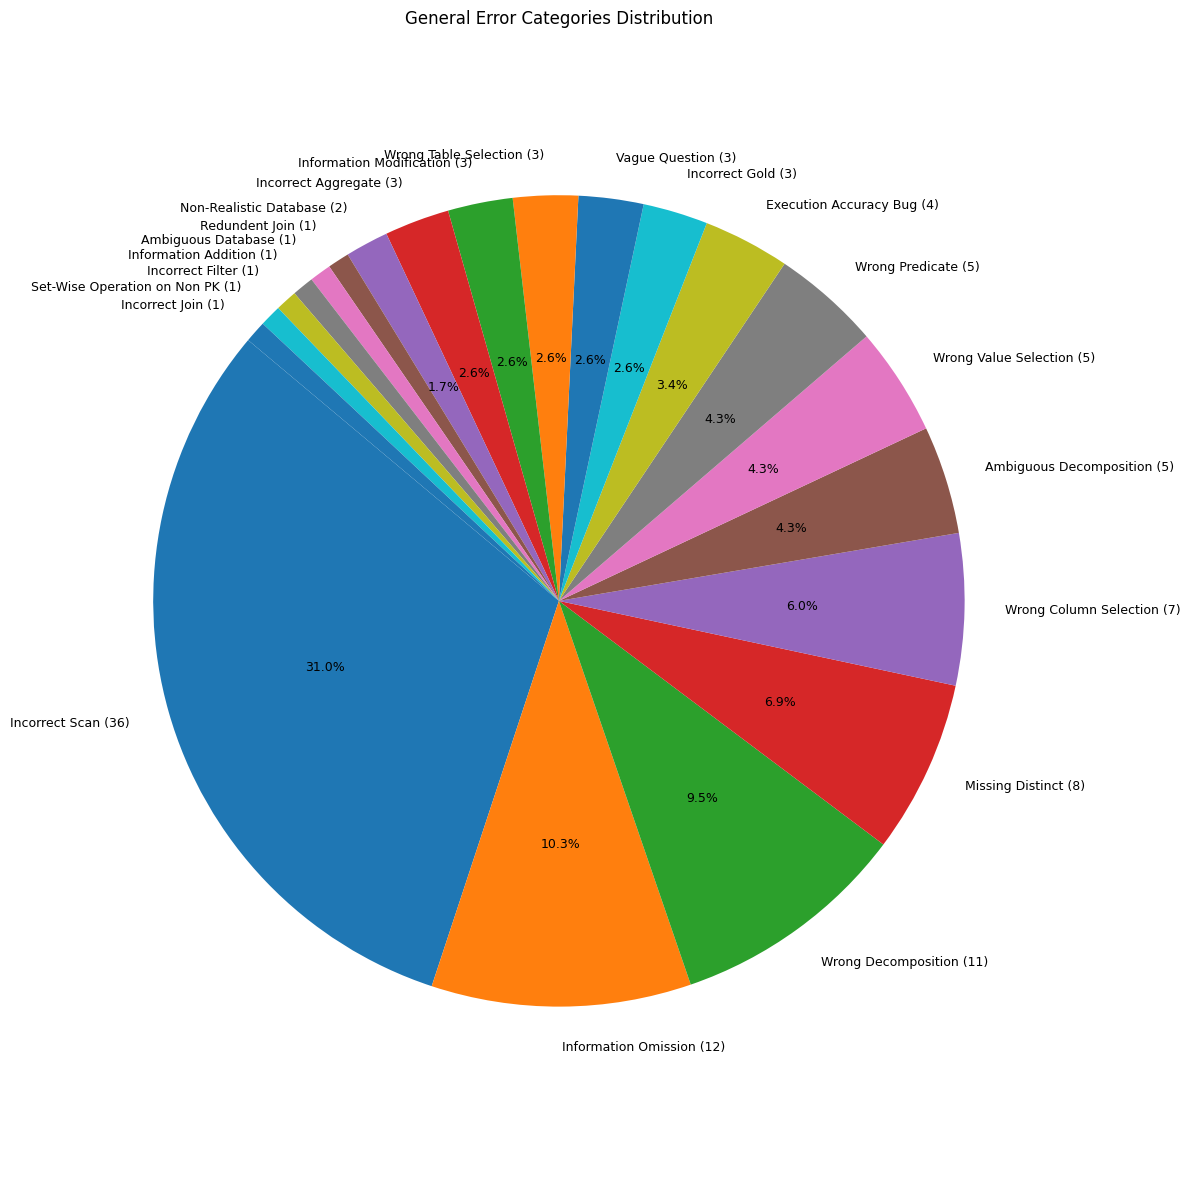

In [46]:
# Show a pie chart of general categories with counts
plt.figure(figsize=(12, 12))

# Create labels with counts
labels = [f"{cat} ({count})" for cat, count in general_categories.items()]

# Only show percentages for significant categories
plt.pie(
    list(general_categories.values()), 
    labels=labels,
    autopct=lambda pct: f'{pct:.1f}%' if pct > 1 else '',
    startangle=140, 
    textprops={'fontsize': 9}
)

plt.title('General Error Categories Distribution')
plt.axis('equal')  # Equal aspect ratio ensures pie is drawn as a circle
plt.tight_layout()
plt.show()

### Error Count Per Component

In [47]:
from enum import StrEnum

class Component(StrEnum):
    DECOMPOSER = 'Decomposer'
    COMPLETER = 'Completer'
    BENCHMARK = 'Benchmark'
    EX_ACC = 'Execution Accuracy'

general_category_to_component = {
    'Incorrect Scan': Component.DECOMPOSER,
    'Information Omission': Component.DECOMPOSER,
    'Wrong Decomposition': Component.DECOMPOSER,
    'Missing Distinct': Component.COMPLETER,
    'Wrong Column Selection': Component.COMPLETER,
    'Ambiguous Decomposition': Component.DECOMPOSER,
    'Wrong Value Selection': Component.COMPLETER,
    'Wrong Predicate': Component.COMPLETER,
    'Execution Accuracy Bug': Component.EX_ACC,
    'Incorrect Gold': Component.BENCHMARK,
    'Vague Question': Component.BENCHMARK,
    'Wrong Table Selection': Component.COMPLETER,
    'Information Modification': Component.DECOMPOSER,
    'Incorrect Aggregate': Component.DECOMPOSER,
    'Non-Realistic Database': Component.BENCHMARK,
    'Redundent Join': Component.DECOMPOSER,
    'Ambiguous Database': Component.BENCHMARK,
    'Information Addition': Component.DECOMPOSER,
    'Incorrect Filter': Component.DECOMPOSER,
    'Set-Wise Operation on Non PK': Component.DECOMPOSER,
    'Incorrect Join': Component.DECOMPOSER
}

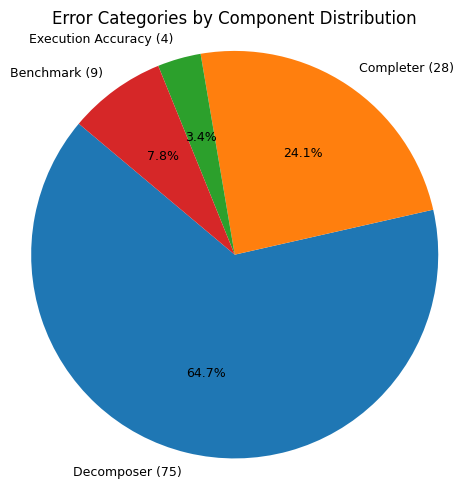

In [50]:
# show a pie chart of components with counts
component_counts = defaultdict(int)
for category, count in general_categories.items():
    component = general_category_to_component.get(category, 'Unknown')
    component_counts[component] += count
plt.figure(figsize=(5, 5))
# Create labels with counts
labels = [f"{comp} ({count})" for comp, count in component_counts.items()]
plt.pie(
    list(component_counts.values()), 
    labels=labels,
    autopct=lambda pct: f'{pct:.1f}%' if pct > 1 else '',
    startangle=140, 
    textprops={'fontsize': 9}
) 
plt.title('Error Categories by Component Distribution')
plt.axis('equal')  # Equal aspect ratio ensures pie is drawn as a circle
plt.tight_layout()
plt.show()